In [1]:
#Importaciones
import pandas as pd
import kagglehub
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import time
import matplotlib.pyplot as plt
import copy

from kagglehub import KaggleDatasetAdapter
from datasets import Dataset, load_dataset
from transformers import AutoTokenizer

c:\Users\Laura\OneDrive\Escritorio\NR-project-ARC\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Descargar archivo
file_path = kagglehub.dataset_download("mexwell/amazon-reviews-multi")

csv_path = file_path + "/train.csv"

df = pd.read_csv(csv_path, encoding="latin-1")

print("Shape:", df.shape)
print("Columnas:", df.columns)
print("Primeras 5 filas:\n", df.head())


Shape: (1200000, 9)
Columnas: Index(['Unnamed: 0', 'review_id', 'product_id', 'reviewer_id', 'stars',
       'review_body', 'review_title', 'language', 'product_category'],
      dtype='object')
Primeras 5 filas:
    Unnamed: 0   review_id          product_id          reviewer_id  stars  \
0           0  de_0203609  product_de_0865382  reviewer_de_0267719      1   
1           1  de_0559494  product_de_0678997  reviewer_de_0783625      1   
2           2  de_0238777  product_de_0372235  reviewer_de_0911426      1   
3           3  de_0477884  product_de_0719501  reviewer_de_0836478      1   
4           4  de_0270868  product_de_0022613  reviewer_de_0736276      1   

                                         review_body  \
0     Armband ist leider nach 1 Jahr kaputt gegangen   
1                 In der Lieferung war nur Ein Akku!   
2  Ein Stern, weil gar keine geht nicht. Es hande...   
3  Dachte, das wÃ¤ren einfach etwas festere Binde...   
4  Meine Kinder haben kaum damit gespielt u

In [3]:
#preprocesamiento. ESTRUCTURA DE LAS REVIEWS

df["text"] = df["review_title"].fillna("") + " " + df["review_body"].fillna("")
df["labels"] = df["stars"] - 1
df = df[["text", "labels", "language"]]

In [4]:
#Conversión a hugging face dataset
dataset = Dataset.from_pandas(df)

#División del dataset train/test
dataset = dataset.train_test_split(test_size=0.1, seed=42)
train_val = dataset["train"].train_test_split(test_size=0.1, seed=42)

train_dataset = train_val["train"]
validation_dataset = train_val["test"]
test_dataset = dataset["test"]

In [6]:
#Tokenización
# NOTA: Si eligen otro modelo. esta parte se corrige dado que la tokenización no será la misma. Yo me encargo de ello
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess(batch):
  return tokenizer(
      batch["text"],
      truncation=True,
      padding="max_length",
      max_length=180
  )

train_dataset = train_dataset.map(preprocess, batched=True)
validation_dataset = validation_dataset.map(preprocess, batched=True)
test_dataset = test_dataset.map(preprocess, batched=True)

train_dataset.set_format(type="torch", columns=["input_ids", "labels"])
validation_dataset.set_format(type="torch", columns=["input_ids", "labels"])
test_dataset.set_format(type="torch", columns=["input_ids", "labels"])

Map: 100%|██████████| 120000/120000 [00:08<00:00, 13776.04 examples/s]


## Arquitectura de Red Neuronal

In [ ]:
class RedNeuronalSimple(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx=0):
        super(RedNeuronalSimple, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        # -------------------------
        # Capa oculta 1: 180 entradas, 128 salidas, ReLU, Dropout 0.2
        # -------------------------
        self.capa_oculta_1 = nn.Linear(embedding_dim, hidden_dim)
        self.activacion_1 = nn.ReLU()
        self.dropout_1 = nn.Dropout(0.2)

        # -------------------------
        # Capa oculta 2: 128 entradas, 64 salidas, ReLU, Dropout 0.2
        # -------------------------
        self.capa_oculta_2 = nn.Linear(hidden_dim, hidden_dim)
        self.activacion_2 = nn.ReLU()
        self.dropout_2 = nn.Dropout(0.2)

        # -------------------------
        # Capa de salida: 64 entradas, 5 salidas (una por clase)
        # -------------------------
        self.capa_salida = nn.Linear(hidden_dim, output_dim)
        # Nota: No ponemos softmax porque nn.CrossEntropyLoss lo aplica internamente

    def forward(self, input_ids):
        # -------------------------
        # Paso por la capa oculta 1
        # -------------------------
        embedded = self.embedding(input_ids)
        pooled = embedded.mean(dim=1)

        x = self.capa_oculta_1(pooled)
        x = self.activacion_1(x)
        x = self.dropout_1(x)

        # -------------------------
        # Paso por la capa oculta 2
        # -------------------------
        x = self.capa_oculta_2(x)
        x = self.activacion_2(x)
        x = self.dropout_2(x)

        # -------------------------
        # Paso por la capa de salida
        # -------------------------
        x = self.capa_salida(x)

        return x

class RedNeuronalIntermedia(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim1=256, hidden_dim2=128, hidden_dim3=64, output_dim=5, pad_idx=0):
        super(RedNeuronalIntermedia, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        # -------------------------
        # Capa oculta 1: 180 entradas, 256 salidas, ReLU, Dropout 0.2
        # -------------------------
        self.capa_oculta_1 = nn.Linear(embedding_dim, hidden_dim1)
        self.activacion_1 = nn.ReLU()
        self.dropout_1 = nn.Dropout(0.2)

        # -------------------------
        # Capa oculta 2: 256 entradas, 128 salidas, ReLU, Dropout 0.2
        # -------------------------
        self.capa_oculta_2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.activacion_2 = nn.ReLU()
        self.dropout_2 = nn.Dropout(0.2)

        # -------------------------
        # Capa de oculta 3: 128 entradas, 64 salidas, ReLU, Dropout 0.2
        # -------------------------
        self.capa_oculta_3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.activacion_3 = nn.ReLU()
        self.dropout_3 = nn.Dropout(0.2)

        # -------------------------
        # Capa de salida: 64 entradas, 5 salidas (una por clase)
        # -------------------------
        self.capa_salida = nn.Linear(hidden_dim3, output_dim)
        # Nota: No ponemos softmax porque nn.CrossEntropyLoss lo aplica internamente

    def forward(self, input_ids):

        embedded = self.embedding(input_ids)
        pooled = embedded.mean(dim=1)
        # -------------------------
        # Paso por la capa oculta 1
        # -------------------------
        x = self.capa_oculta_1(pooled)
        x = self.activacion_1(x)
        x = self.dropout_1(x)

        # -------------------------
        # Paso por la capa oculta 2
        # -------------------------
        x = self.capa_oculta_2(x)
        x = self.activacion_2(x)
        x = self.dropout_2(x)

        # -------------------------
        # Paso por la capa oculta 3
        # -------------------------
        x = self.capa_oculta_3(x)
        x = self.activacion_3(x)
        x = self.dropout_3(x)

        # -------------------------
        # Paso por la capa de salida
        # -------------------------
        x = self.capa_salida(x)

        return x

class RedNeuronalAvanzada(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim1=512, hidden_dim2=256, hidden_dim3=128, hidden_dim4=64, output_dim=5, pad_idx=0):
        super(RedNeuronalAvanzada, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        # -------------------------
        # Capa oculta 1: 180 entradas, 512 salidas, ReLU, Dropout 0.2
        # -------------------------
        self.capa_oculta_1 = nn.Linear(embedding_dim, hidden_dim1)
        self.activacion_1 = nn.ReLU()
        self.dropout_1 = nn.Dropout(0.2)

        # -------------------------
        # Capa oculta 2: 512 entradas, 256 salidas, ReLU, Dropout 0.2
        # -------------------------
        self.capa_oculta_2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.activacion_2 = nn.ReLU()
        self.dropout_2 = nn.Dropout(0.2)

        # -------------------------
        # Capa oculta 3: 256 entradas, 128 salidas, ReLU, Dropout 0.2
        # -------------------------
        self.capa_oculta_3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.activacion_3 = nn.ReLU()
        self.dropout_3 = nn.Dropout(0.2)

        # -------------------------
        # Capa oculta 4: 128 entradas, 64 salidas, ReLU, Dropout 0.2
        # -------------------------
        self.capa_oculta_4 = nn.Linear(hidden_dim3, hidden_dim4)
        self.activacion_4 = nn.ReLU()
        self.dropout_4 = nn.Dropout(0.2)

        # -------------------------
        # Capa de salida: 64 entradas, 5 salidas (una por clase)
        # -------------------------
        self.capa_salida = nn.Linear(hidden_dim4, output_dim)
        # Nota: No ponemos softmax porque nn.CrossEntropyLoss lo aplica internamente

    def forward(self, input_ids):

        embedded = self.embedding(input_ids)
        pooled = embedded.mean(dim=1)
        # -------------------------
        # Paso por la capa oculta 1
        # -------------------------
        x = self.capa_oculta_1(pooled)
        x = self.activacion_1(x)
        x = self.dropout_1(x)

        # -------------------------
        # Paso por la capa oculta 2
        # -------------------------
        x = self.capa_oculta_2(x)
        x = self.activacion_2(x)
        x = self.dropout_2(x)

        # -------------------------
        # Paso por la capa oculta 3
        # -------------------------
        x = self.capa_oculta_3(x)
        x = self.activacion_3(x)
        x = self.dropout_3(x)

        # -------------------------
        # Paso por la capa oculta 4
        # -------------------------
        x = self.capa_oculta_4(x)
        x = self.activacion_4(x)
        x = self.dropout_4(x)

        # -------------------------
        # Paso por la capa de salida
        # -------------------------
        x = self.capa_salida(x)

        return x

def setup_training(model, learning_rate=0.001):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    return optimizer, criterion

#### Entrenamiento


In [ ]:
# Configuración del dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔧 Dispositivo de entrenamiento: {device}")

# Función de entrenamiento por época
def train_epoch(model, train_loader, optimizer, criterion, device):
    """Entrena el modelo por una época"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch in train_loader:
        # Obtener datos del batch (ya están en formato torch)
        inputs = batch['input_ids'].to(device, dtype=torch.long)  # Convertir a float para compatibilidad
        labels = batch['labels'].to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Estadísticas
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total

    return epoch_loss, epoch_accuracy

# Función de evaluación
def evaluate_model(model, val_loader, criterion, device):
    """Evalúa el modelo en el conjunto de validación"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_loader:
            inputs = batch['input_ids'].to(device, dtype=torch.long)
            labels = batch['labels'].to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(val_loader)
    val_accuracy = 100 * correct / total

    return val_loss, val_accuracy

# Función principal de entrenamiento
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs, device, model_name, exp_name):
    """Función principal de entrenamiento con guardado del mejor modelo"""
    print(f"\n🚀 Iniciando entrenamiento - {model_name} - {exp_name}")
    print("=" * 70)

    # Métricas para seguimiento
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # Variables para el mejor modelo
    best_val_accuracy = 0.0
    best_model_state = None
    best_epoch = 0

    patience = max(1, epochs // 4)
    patience_counter = 0

    # Loop de entrenamiento
    for epoch in range(epochs):
        print(f"\n📊 Época {epoch + 1}/{epochs}")
        print("-" * 50)

        # Entrenar una época
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)

        # Evaluar en validación
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)

        # Guardar métricas
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Guardar mejor modelo
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            best_model_state = model.state_dict().copy()
            best_epoch = epoch + 1
            patience_counter = 0


        # Imprimir métricas
        #print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        #print(f"Val Loss: {val_loss:.4f}   | Val Acc: {val_acc:.2f}%")

        # Indicar si es el mejor modelo hasta ahora
        #if val_acc == best_val_accuracy:
            print("🌟 ¡Nuevo mejor modelo!")
        else: 
          patience_counter += 1
          print(f"⏳ Sin mejora en val_acc. Paciencia: {patience_counter}/{patience}")
        
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}   | Val Acc: {val_acc:.2f}%")

    # Cargar el mejor modelo
    #model.load_state_dict(best_model_state)

    if best_model_state is not None:
      model.load_state_dict(best_model_state)
      
    print(f"\n✅ Entrenamiento completado!")
    print(f"🏆 Mejor modelo: Época {best_epoch} con Val Accuracy: {best_val_accuracy:.2f}%")

    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'best_val_accuracy': best_val_accuracy,
        'best_epoch': best_epoch,
        'stopped_epoch': epoch +1,
        'model': model
    }

🔧 Dispositivo de entrenamiento: cpu


In [ ]:
# EJECUCIÓN DE TODOS LOS EXPERIMENTOS
print("🎯 INICIANDO EXPERIMENTOS DE REDES NEURONALES")
print("=" * 80)

# Definición de modelos y experimentos
models_dict = {
    'RedNeuronalSimple': RedNeuronalSimple,
    'RedNeuronalIntermedia': RedNeuronalIntermedia,
    'RedNeuronalAvanzada': RedNeuronalAvanzada
}

experiments = {
    "exp_1": {"learning_rate": 0.001, "epochs": 100, "batch_size": 1024},
    "exp_2": {"learning_rate": 0.0005, "epochs": 500, "batch_size": 2048},
}

vocab_size = len(tokenizer.vocab)  
embedding_dim = 180 

output_dim = 5                
pad_idx = tokenizer.pad_token_id 

# Diccionario para almacenar todos los resultados
all_results = {}

# Ejecutar experimentos para cada modelo y configuración
for model_name, ModelClass in models_dict.items():
    print(f"\n🔬 MODELO: {model_name}")
    print("=" * 60)

    model_results = {}

    for exp_name, params in experiments.items():
        print(f"\n📋 Experimento: {exp_name}")
        print(f"   Parámetros: {params}")

        # Crear DataLoaders con batch_size específico del experimento
        train_loader = DataLoader(train_dataset,
                                 batch_size=params["batch_size"],
                                 shuffle=True)
        val_loader = DataLoader(validation_dataset,
                               batch_size=params["batch_size"],
                               shuffle=False)

        # Crear modelo fresco para cada experimento
        if model_name == "RedNeuronalSimple":
            model = ModelClass(vocab_size, embedding_dim, 128, output_dim, pad_idx).to(device)
        elif model_name == "RedNeuronalIntermedia":
            model = ModelClass(vocab_size, embedding_dim, output_dim=output_dim, pad_idx=pad_idx).to(device)
        elif model_name == "RedNeuronalAvanzada":
            model = ModelClass(vocab_size, embedding_dim, output_dim=output_dim, pad_idx=pad_idx).to(device)

        optimizer, criterion = setup_training(model, learning_rate=params["learning_rate"])


        # Entrenar modelo
        results = train_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            optimizer=optimizer,
            criterion=criterion,
            epochs=params["epochs"],
            device=device,
            model_name=model_name,
            exp_name=exp_name
        )

        # Guardar resultados
        results['params'] = params
        model_results[exp_name] = results

    # Guardar resultados del modelo
    all_results[model_name] = model_results

print(f"\n🎉 TODOS LOS EXPERIMENTOS COMPLETADOS")
print("=" * 80)

🎯 INICIANDO EXPERIMENTOS DE REDES NEURONALES

🔬 MODELO: RedNeuronalSimple

📋 Experimento: exp_1
   Parámetros: {'learning_rate': 0.001, 'epochs': 100, 'batch_size': 1024}

🚀 Iniciando entrenamiento - RedNeuronalSimple - exp_1

📊 Época 1/100
--------------------------------------------------
Train Loss: 59.9471 | Train Acc: 19.98%
Val Loss: 1.6094   | Val Acc: 20.06%
🌟 ¡Nuevo mejor modelo!

📊 Época 2/100
--------------------------------------------------
Train Loss: 1.6495 | Train Acc: 20.05%
Val Loss: 1.6095   | Val Acc: 19.93%

📊 Época 3/100
--------------------------------------------------
Train Loss: 1.6214 | Train Acc: 19.97%
Val Loss: 1.6095   | Val Acc: 19.97%

📊 Época 4/100
--------------------------------------------------
Train Loss: 1.6167 | Train Acc: 19.99%
Val Loss: 1.6094   | Val Acc: 20.03%

📊 Época 5/100
--------------------------------------------------
Train Loss: 1.6130 | Train Acc: 20.01%
Val Loss: 1.6095   | Val Acc: 19.97%

📊 Época 6/100
-------------------------

In [11]:
# GUARDAR RESULTADOS EN ARCHIVOS CSV
print("\n💾 GUARDANDO RESULTADOS EN ARCHIVOS CSV")
print("=" * 60)

import os

# Crear directorio de resultados si no existe
results_dir = "resultados"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    print(f"📁 Directorio '{results_dir}' creado")

# Mapeo de nombres de modelos a nombres de archivos
file_mapping = {
    'RedNeuronalSimple': 'resultados_simple.csv',
    'RedNeuronalIntermedia': 'resultados_intermedia.csv',
    'RedNeuronalAvanzada': 'resultados_avanzada.csv'
}

# Guardar resultados de cada modelo
for model_name, model_results in all_results.items():
    # Crear lista para almacenar datos del CSV
    csv_data = []
    
    print(f"\n📊 Procesando {model_name}...")
    
    # Procesar cada experimento del modelo
    for exp_name, results in model_results.items():
        params = results['params']
        
        # Crear fila base con información del experimento
        base_row = {
            'modelo': model_name,
            'experimento': exp_name,
            'learning_rate': params['learning_rate'],
            'epochs_total': params['epochs'],
            'batch_size': params['batch_size'],
            'mejor_epoch': results['best_epoch'],
            'mejor_val_accuracy': results['best_val_accuracy']
        }
        
        # Agregar métricas por época
        for epoch in range(len(results['train_losses'])):
            row = base_row.copy()
            row.update({
                'epoca': epoch + 1,
                'train_loss': results['train_losses'][epoch],
                'train_accuracy': results['train_accuracies'][epoch],
                'val_loss': results['val_losses'][epoch],
                'val_accuracy': results['val_accuracies'][epoch],
                'es_mejor_modelo': (epoch + 1) == results['best_epoch']
            })
            csv_data.append(row)
    
    # Convertir a DataFrame y guardar
    df_results = pd.DataFrame(csv_data)
    
    # Ordenar por experimento y época para mejor lectura
    df_results = df_results.sort_values(['experimento', 'epoca'])
    
    # Nombre del archivo
    filename = file_mapping[model_name]
    filepath = os.path.join(results_dir, filename)
    
    # Guardar CSV
    df_results.to_csv(filepath, index=False, encoding='utf-8')
    
    print(f"   ✅ {filename} guardado ({len(df_results)} filas)")
    print(f"      Columnas: {list(df_results.columns)}")

print(f"\n🎉 TODOS LOS ARCHIVOS CSV GUARDADOS EN '{results_dir}/'")
print("=" * 60)

# Mostrar resumen de archivos creados
print("\n📋 ARCHIVOS CREADOS:")
for model_name, filename in file_mapping.items():
    filepath = os.path.join(results_dir, filename)
    if os.path.exists(filepath):
        file_size = os.path.getsize(filepath)
        print(f"   📄 {filename} ({file_size:,} bytes)")
        
        # Mostrar preview de las primeras filas
        df_preview = pd.read_csv(filepath, nrows=3)
        print(f"      Preview: {len(df_preview)} filas de muestra")

print(f"\n💡 Para cargar los resultados posteriormente:")
print(f"   df_simple = pd.read_csv('{results_dir}/resultados_simple.csv')")
print(f"   df_intermedia = pd.read_csv('{results_dir}/resultados_intermedia.csv')")
print(f"   df_avanzada = pd.read_csv('{results_dir}/resultados_avanzada.csv')")


💾 GUARDANDO RESULTADOS EN ARCHIVOS CSV
📁 Directorio 'resultados' creado

📊 Procesando RedNeuronalSimple...
   ✅ resultados_simple.csv guardado (600 filas)
      Columnas: ['modelo', 'experimento', 'learning_rate', 'epochs_total', 'batch_size', 'mejor_epoch', 'mejor_val_accuracy', 'epoca', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy', 'es_mejor_modelo']

📊 Procesando RedNeuronalIntermedia...
   ✅ resultados_intermedia.csv guardado (600 filas)
      Columnas: ['modelo', 'experimento', 'learning_rate', 'epochs_total', 'batch_size', 'mejor_epoch', 'mejor_val_accuracy', 'epoca', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy', 'es_mejor_modelo']

📊 Procesando RedNeuronalAvanzada...
   ✅ resultados_avanzada.csv guardado (600 filas)
      Columnas: ['modelo', 'experimento', 'learning_rate', 'epochs_total', 'batch_size', 'mejor_epoch', 'mejor_val_accuracy', 'epoca', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy', 'es_mejor_modelo']

🎉 TODOS LOS ARCHIVOS CS

In [12]:
# RESUMEN FINAL DE RESULTADOS
print("\n📈 RESUMEN FINAL DE TODOS LOS EXPERIMENTOS")
print("=" * 80)

# Tabla de resultados
print(f"{'Modelo':<20} {'Experimento':<12} {'Val Accuracy':<15} {'Mejor Época':<12} {'LR':<8} {'Batch':<8}")
print("-" * 80)

best_overall = {'accuracy': 0, 'model': '', 'exp': '', 'epoch': 0}

for model_name, model_results in all_results.items():
    for exp_name, results in model_results.items():
        accuracy = results['best_val_accuracy']
        epoch = results['best_epoch']
        lr = results['params']['learning_rate']
        batch_size = results['params']['batch_size']
        
        print(f"{model_name:<20} {exp_name:<12} {accuracy:<15.2f}% {epoch:<12} {lr:<8} {batch_size:<8}")
        
        # Tracking del mejor resultado general
        if accuracy > best_overall['accuracy']:
            best_overall['accuracy'] = accuracy
            best_overall['model'] = model_name
            best_overall['exp'] = exp_name
            best_overall['epoch'] = epoch


📈 RESUMEN FINAL DE TODOS LOS EXPERIMENTOS
Modelo               Experimento  Val Accuracy    Mejor Época  LR       Batch   
--------------------------------------------------------------------------------
RedNeuronalSimple    exp_1        20.06          % 1            0.001    1024    
RedNeuronalSimple    exp_2        20.06          % 26           0.0005   2048    
RedNeuronalIntermedia exp_1        20.06          % 11           0.001    1024    
RedNeuronalIntermedia exp_2        20.06          % 29           0.0005   2048    
RedNeuronalAvanzada  exp_1        20.06          % 8            0.001    1024    
RedNeuronalAvanzada  exp_2        20.06          % 4            0.0005   2048    


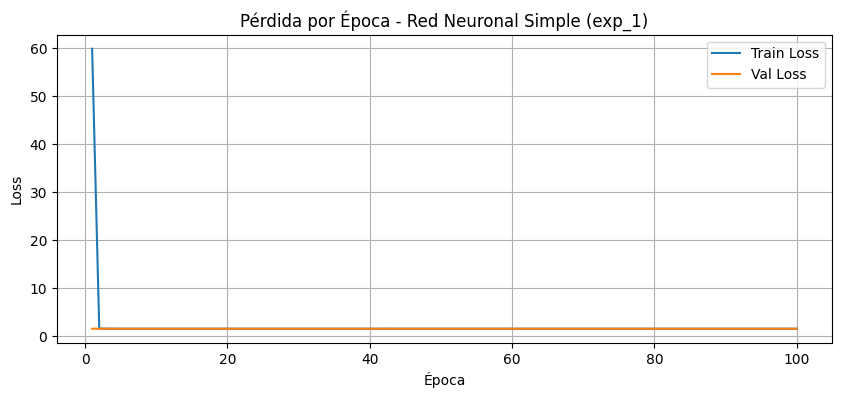

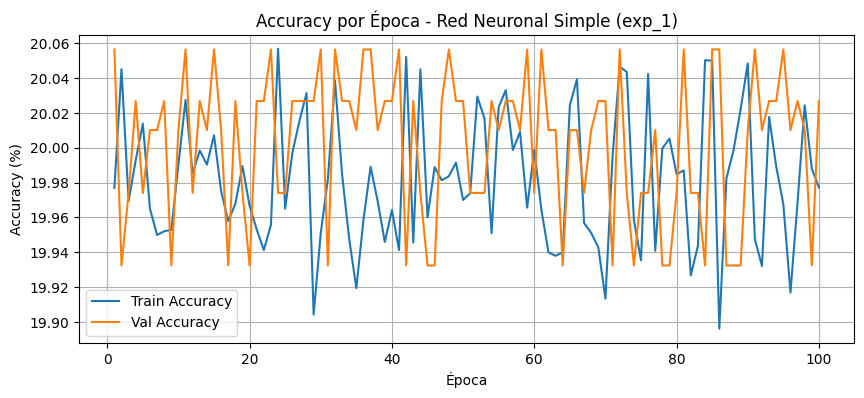

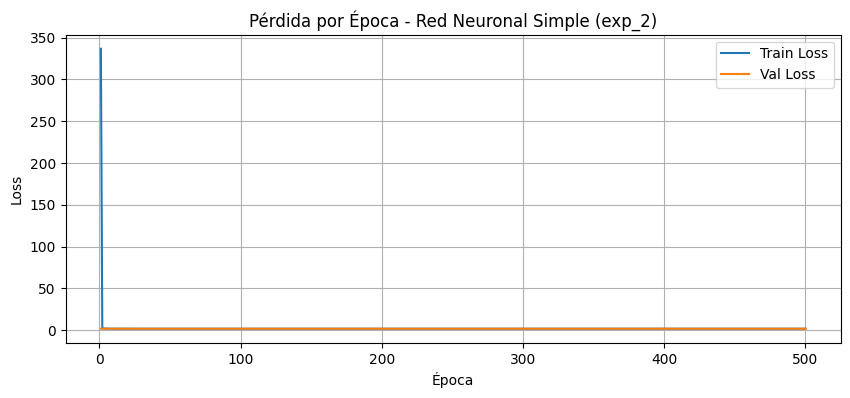

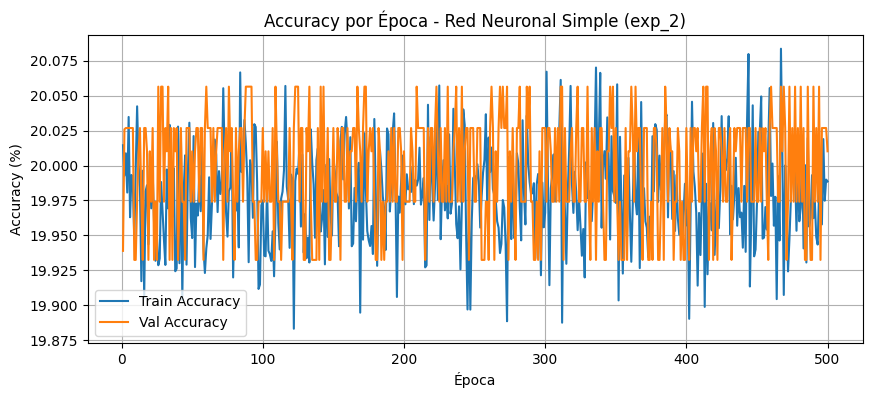

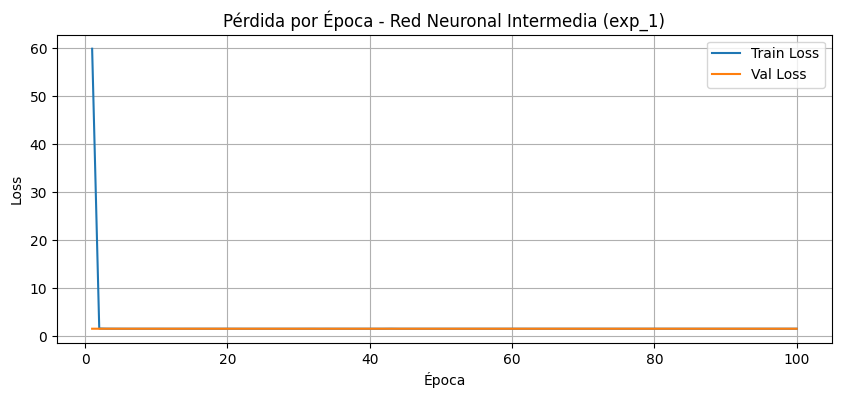

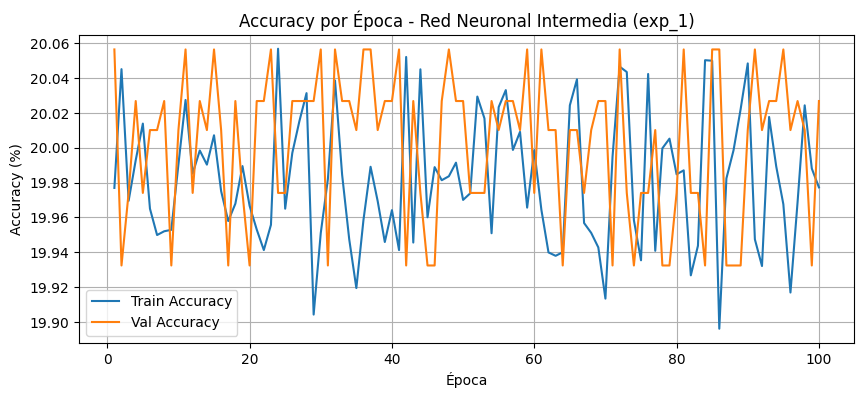

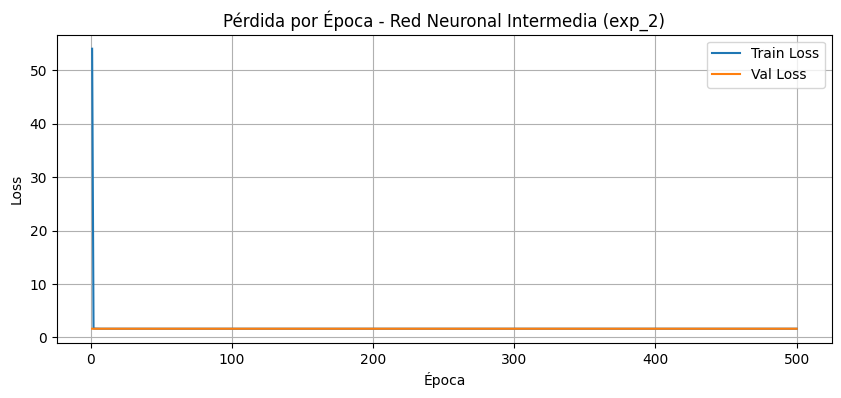

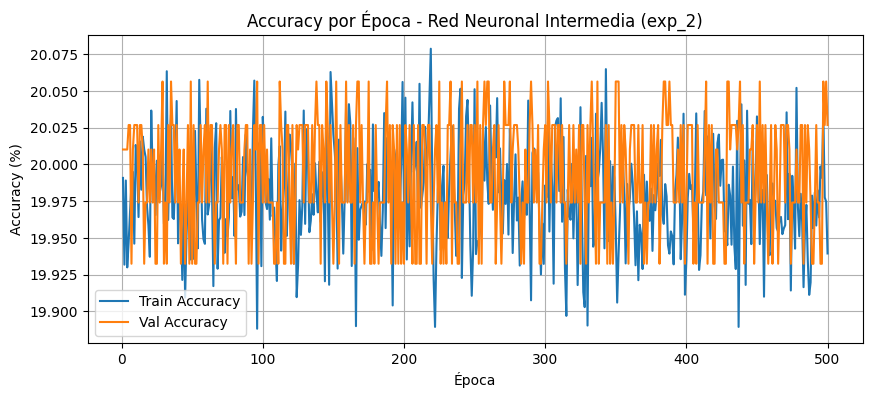

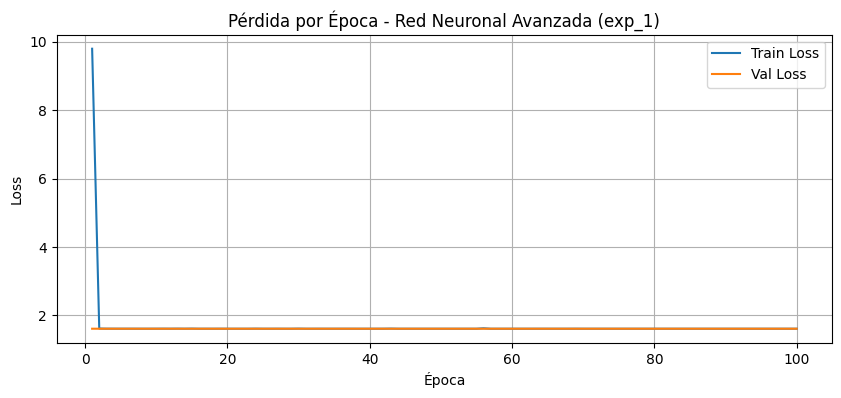

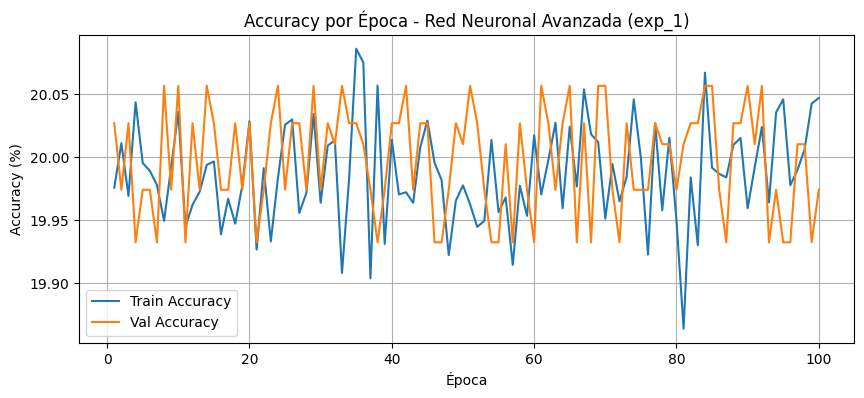

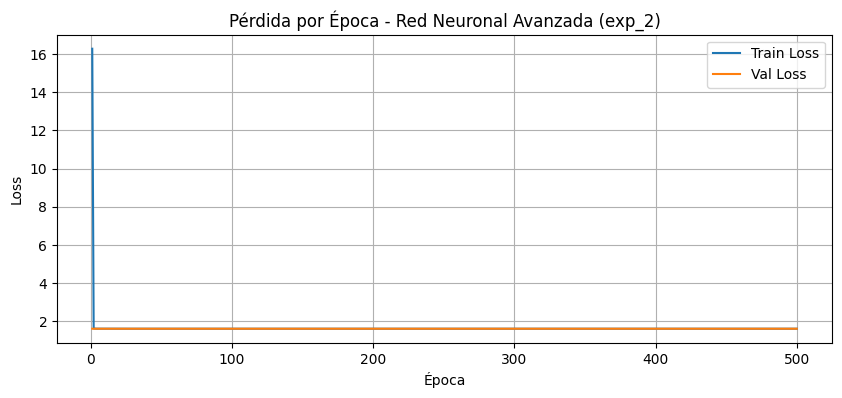

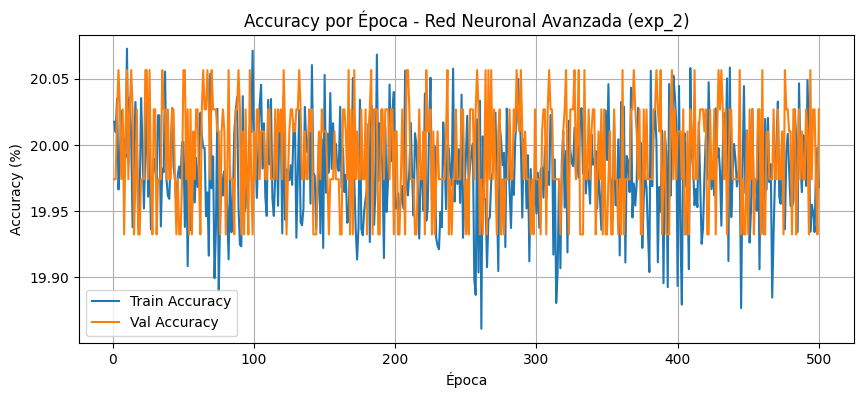

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_curvas(filepath, titulo, experimento):
    # Leer CSV
    df = pd.read_csv(filepath)
    
    # Filtrar solo el experimento deseado
    df = df[df["experimento"] == experimento]
    
    # Gráfica de pérdida
    plt.figure(figsize=(10, 4))
    plt.plot(df["epoca"], df["train_loss"], label="Train Loss")
    plt.plot(df["epoca"], df["val_loss"], label="Val Loss")
    plt.title(f"Pérdida por Época - {titulo} ({experimento})")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Gráfica de accuracy
    plt.figure(figsize=(10, 4))
    plt.plot(df["epoca"], df["train_accuracy"], label="Train Accuracy")
    plt.plot(df["epoca"], df["val_accuracy"], label="Val Accuracy")
    plt.title(f"Accuracy por Época - {titulo} ({experimento})")
    plt.xlabel("Época")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_curvas("./resultados/resultados_simple.csv", "Red Neuronal Simple", "exp_1")
plot_curvas("./resultados/resultados_simple.csv", "Red Neuronal Simple", "exp_2")
plot_curvas("./resultados/resultados_simple.csv", "Red Neuronal Intermedia", "exp_1")
plot_curvas("./resultados/resultados_intermedia.csv", "Red Neuronal Intermedia", "exp_2")
plot_curvas("./resultados/resultados_avanzada.csv", "Red Neuronal Avanzada", "exp_1")
plot_curvas("./resultados/resultados_avanzada.csv", "Red Neuronal Avanzada", "exp_2")



In [14]:
import os
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# ============================================
# 1. Modelos con nn.Embedding + pooling
# ============================================
class BaseMLP(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_layers, num_classes=5, max_length=180):
        super(BaseMLP, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.max_length = max_length

        layers = []
        input_dim = embedding_dim
        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))
            input_dim = hidden_dim

        layers.append(nn.Linear(input_dim, num_classes))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        emb = self.embedding(x)  # [batch, seq_len, embedding_dim]
        pooled = emb.mean(dim=1) # promedio de embeddings
        return self.network(pooled)

# Definición de las tres variantes
def RedNeuronalSimple(vocab_size, embedding_dim=128): 
    return BaseMLP(vocab_size, embedding_dim, hidden_layers=[128])

def RedNeuronalIntermedia(vocab_size, embedding_dim=128): 
    return BaseMLP(vocab_size, embedding_dim, hidden_layers=[256, 128, 64])

def RedNeuronalAvanzada(vocab_size, embedding_dim=128): 
    return BaseMLP(vocab_size, embedding_dim, hidden_layers=[512, 256, 128, 64])


# ============================================
# 2. Funciones de entrenamiento y evaluación
# ============================================
def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for batch in train_loader:
        inputs = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return running_loss / len(train_loader), 100 * correct / total


def evaluate_model(model, val_loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_labels, all_preds = [], []

    with torch.no_grad():
        for batch in val_loader:
            inputs = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    return (
        running_loss / len(val_loader),
        100 * correct / total,
        np.array(all_labels),
        np.array(all_preds)
    )

# ============================================
# 3. Entrenamiento con Early Stopping
# ============================================
def train_model_es(model, train_loader, val_loader, optimizer, criterion, epochs, device, patience=25):
    best_val_accuracy, best_model_state, best_epoch = 0.0, None, 0
    no_improve_epochs = 0

    history = {"epoch": [], "train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc, _, _ = evaluate_model(model, val_loader, criterion, device)

        history["epoch"].append(epoch+1)
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"📊 Época {epoch+1}/{epochs} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            best_model_state = model.state_dict().copy()
            best_epoch = epoch + 1
            no_improve_epochs = 0
            print("🌟 Nuevo mejor modelo!")
        else:
            no_improve_epochs += 1

        if no_improve_epochs >= patience:
            print(f"⏹️ Early Stopping activado en época {epoch+1}")
            break

    model.load_state_dict(best_model_state)
    print(f"\n🏆 Mejor modelo en época {best_epoch} con Val Accuracy: {best_val_accuracy:.2f}%")

    return model, best_val_accuracy, best_epoch, pd.DataFrame(history)

# ============================================
# 4. Evaluación final con métricas adicionales
# ============================================
def evaluar_metricas(model, test_loader, criterion, device, nombre_modelo, exp_name):
    model.eval()
    _, acc, y_true, y_pred = evaluate_model(model, test_loader, criterion, device)

    print("\n📊 Evaluación final en Test Set")
    print("Accuracy:", acc)
    print("F1-score Macro:", f1_score(y_true, y_pred, average="macro"))
    print("F1-score Micro:", f1_score(y_true, y_pred, average="micro"))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matriz de confusión - {nombre_modelo} ({exp_name})")
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.show()

# ============================================
# 5. Guardado de resultados
# ============================================
results_dir = "resultados"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

resultados_globales = []

def guardar_resultados(nombre_modelo, exp_name, params, best_epoch, best_val_accuracy, history):
    filename = f"{nombre_modelo.lower()}_{exp_name}_idioma.csv"
    filepath = os.path.join(results_dir, filename)

    # Guardar todas las épocas
    history["modelo"] = nombre_modelo
    history["experimento"] = exp_name
    history["learning_rate"] = params["learning_rate"]
    history["batch_size"] = params["batch_size"]
    history["epochs_total"] = params["epochs"]
    history["mejor_epoch"] = best_epoch
    history["mejor_val_accuracy"] = best_val_accuracy

    history.to_csv(filepath, index=False)
    print(f"✅ Resultados completos guardados en {filepath}")

    # Agregar al resumen global
    resultados_globales.append({
        "modelo": nombre_modelo,
        "experimento": exp_name,
        "lr": params["learning_rate"],
        "batch_size": params["batch_size"],
        "mejor_epoch": best_epoch,
        "mejor_val_accuracy": best_val_accuracy
    })

# ============================================
# 6. Resumen consolidado
# ============================================
def mostrar_resumen():
    df_resumen = pd.DataFrame(resultados_globales)
    print("\n📈 RESUMEN CONSOLIDADO:")
    print(df_resumen)
    return df_resumen

🔧 Dispositivo de entrenamiento: cpu
📚 Tamaño del vocabulario: 250002

🚀 Entrenando RedNeuronalSimple - exp_1
📊 Época 1/100 | Train Acc: 26.49% | Val Acc: 38.66%
🌟 Nuevo mejor modelo!
📊 Época 2/100 | Train Acc: 42.69% | Val Acc: 45.98%
🌟 Nuevo mejor modelo!
📊 Época 3/100 | Train Acc: 50.36% | Val Acc: 52.67%
🌟 Nuevo mejor modelo!
📊 Época 4/100 | Train Acc: 53.58% | Val Acc: 53.91%
🌟 Nuevo mejor modelo!
📊 Época 5/100 | Train Acc: 55.70% | Val Acc: 55.39%
🌟 Nuevo mejor modelo!
📊 Época 6/100 | Train Acc: 56.81% | Val Acc: 56.10%
🌟 Nuevo mejor modelo!
📊 Época 7/100 | Train Acc: 57.77% | Val Acc: 56.42%
🌟 Nuevo mejor modelo!
📊 Época 8/100 | Train Acc: 58.61% | Val Acc: 57.62%
🌟 Nuevo mejor modelo!
📊 Época 9/100 | Train Acc: 59.23% | Val Acc: 57.66%
🌟 Nuevo mejor modelo!
📊 Época 10/100 | Train Acc: 59.89% | Val Acc: 58.15%
🌟 Nuevo mejor modelo!
📊 Época 11/100 | Train Acc: 60.32% | Val Acc: 59.00%
🌟 Nuevo mejor modelo!
📊 Época 12/100 | Train Acc: 60.74% | Val Acc: 58.82%
📊 Época 13/100 | Train

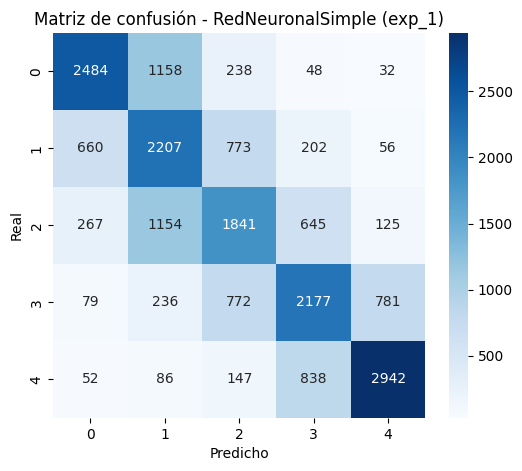


🚀 Entrenando RedNeuronalSimple - exp_2
📊 Época 1/400 | Train Acc: 22.34% | Val Acc: 27.21%
🌟 Nuevo mejor modelo!
📊 Época 2/400 | Train Acc: 26.74% | Val Acc: 25.79%
📊 Época 3/400 | Train Acc: 32.71% | Val Acc: 32.39%
🌟 Nuevo mejor modelo!
📊 Época 4/400 | Train Acc: 39.28% | Val Acc: 42.86%
🌟 Nuevo mejor modelo!
📊 Época 5/400 | Train Acc: 44.09% | Val Acc: 45.04%
🌟 Nuevo mejor modelo!
📊 Época 6/400 | Train Acc: 47.10% | Val Acc: 49.71%
🌟 Nuevo mejor modelo!
📊 Época 7/400 | Train Acc: 49.18% | Val Acc: 48.64%
📊 Época 8/400 | Train Acc: 50.94% | Val Acc: 51.32%
🌟 Nuevo mejor modelo!
📊 Época 9/400 | Train Acc: 52.08% | Val Acc: 52.76%
🌟 Nuevo mejor modelo!
📊 Época 10/400 | Train Acc: 53.21% | Val Acc: 53.75%
🌟 Nuevo mejor modelo!
📊 Época 11/400 | Train Acc: 54.05% | Val Acc: 54.37%
🌟 Nuevo mejor modelo!
📊 Época 12/400 | Train Acc: 54.92% | Val Acc: 54.59%
🌟 Nuevo mejor modelo!
📊 Época 13/400 | Train Acc: 55.39% | Val Acc: 55.58%
🌟 Nuevo mejor modelo!
📊 Época 14/400 | Train Acc: 55.96% | V

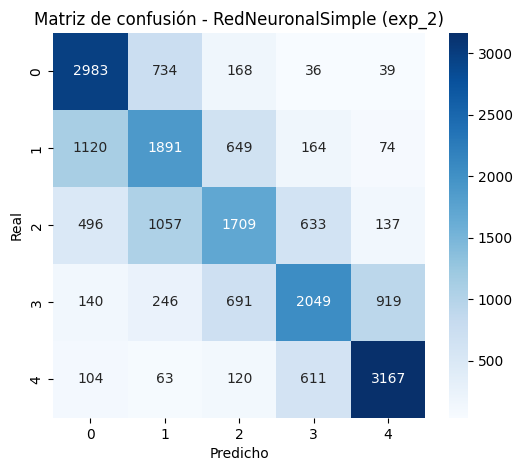


🚀 Entrenando RedNeuronalIntermedia - exp_1
📊 Época 1/100 | Train Acc: 25.21% | Val Acc: 37.12%
🌟 Nuevo mejor modelo!
📊 Época 2/100 | Train Acc: 41.55% | Val Acc: 43.34%
🌟 Nuevo mejor modelo!
📊 Época 3/100 | Train Acc: 49.35% | Val Acc: 52.71%
🌟 Nuevo mejor modelo!
📊 Época 4/100 | Train Acc: 52.68% | Val Acc: 53.33%
🌟 Nuevo mejor modelo!
📊 Época 5/100 | Train Acc: 54.27% | Val Acc: 56.44%
🌟 Nuevo mejor modelo!
📊 Época 6/100 | Train Acc: 56.25% | Val Acc: 57.22%
🌟 Nuevo mejor modelo!
📊 Época 7/100 | Train Acc: 57.22% | Val Acc: 56.84%
📊 Época 8/100 | Train Acc: 57.76% | Val Acc: 55.44%
📊 Época 9/100 | Train Acc: 58.47% | Val Acc: 57.19%
📊 Época 10/100 | Train Acc: 58.77% | Val Acc: 57.33%
🌟 Nuevo mejor modelo!
📊 Época 11/100 | Train Acc: 59.08% | Val Acc: 58.35%
🌟 Nuevo mejor modelo!
📊 Época 12/100 | Train Acc: 59.80% | Val Acc: 58.43%
🌟 Nuevo mejor modelo!
📊 Época 13/100 | Train Acc: 60.44% | Val Acc: 57.64%
📊 Época 14/100 | Train Acc: 60.81% | Val Acc: 59.14%
🌟 Nuevo mejor modelo!
📊 É

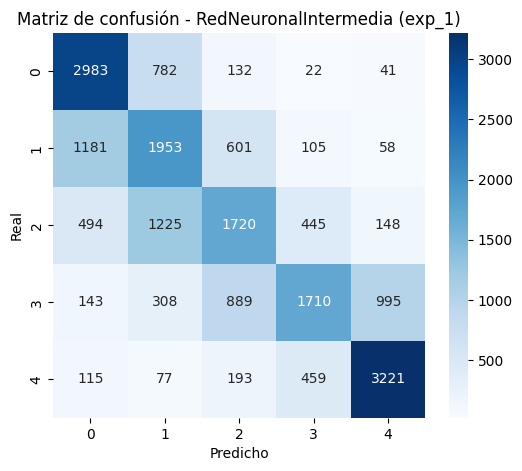


🚀 Entrenando RedNeuronalIntermedia - exp_2
📊 Época 1/400 | Train Acc: 21.81% | Val Acc: 23.97%
🌟 Nuevo mejor modelo!
📊 Época 2/400 | Train Acc: 25.99% | Val Acc: 29.83%
🌟 Nuevo mejor modelo!
📊 Época 3/400 | Train Acc: 34.48% | Val Acc: 38.94%
🌟 Nuevo mejor modelo!
📊 Época 4/400 | Train Acc: 41.43% | Val Acc: 43.40%
🌟 Nuevo mejor modelo!
📊 Época 5/400 | Train Acc: 45.47% | Val Acc: 45.92%
🌟 Nuevo mejor modelo!
📊 Época 6/400 | Train Acc: 48.75% | Val Acc: 51.03%
🌟 Nuevo mejor modelo!
📊 Época 7/400 | Train Acc: 50.43% | Val Acc: 52.33%
🌟 Nuevo mejor modelo!
📊 Época 8/400 | Train Acc: 51.82% | Val Acc: 49.83%
📊 Época 9/400 | Train Acc: 52.87% | Val Acc: 53.46%
🌟 Nuevo mejor modelo!
📊 Época 10/400 | Train Acc: 53.91% | Val Acc: 54.29%
🌟 Nuevo mejor modelo!
📊 Época 11/400 | Train Acc: 54.95% | Val Acc: 54.92%
🌟 Nuevo mejor modelo!
📊 Época 12/400 | Train Acc: 55.42% | Val Acc: 52.08%
📊 Época 13/400 | Train Acc: 55.65% | Val Acc: 56.28%
🌟 Nuevo mejor modelo!
📊 Época 14/400 | Train Acc: 56.26%

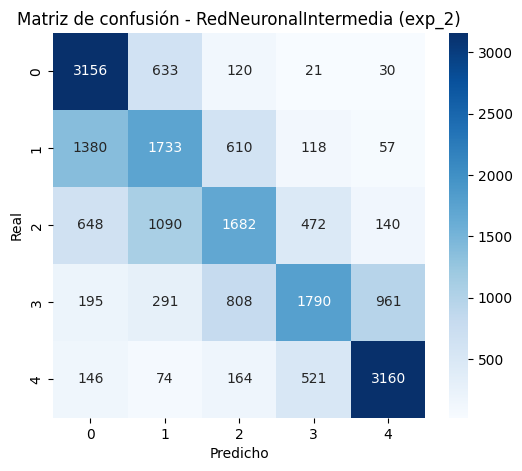


🚀 Entrenando RedNeuronalAvanzada - exp_1
📊 Época 1/100 | Train Acc: 24.92% | Val Acc: 34.51%
🌟 Nuevo mejor modelo!
📊 Época 2/100 | Train Acc: 39.79% | Val Acc: 46.16%
🌟 Nuevo mejor modelo!
📊 Época 3/100 | Train Acc: 48.11% | Val Acc: 50.39%
🌟 Nuevo mejor modelo!
📊 Época 4/100 | Train Acc: 51.26% | Val Acc: 51.15%
🌟 Nuevo mejor modelo!
📊 Época 5/100 | Train Acc: 53.68% | Val Acc: 55.47%
🌟 Nuevo mejor modelo!
📊 Época 6/100 | Train Acc: 55.65% | Val Acc: 55.61%
🌟 Nuevo mejor modelo!
📊 Época 7/100 | Train Acc: 56.54% | Val Acc: 53.45%
📊 Época 8/100 | Train Acc: 57.18% | Val Acc: 57.23%
🌟 Nuevo mejor modelo!
📊 Época 9/100 | Train Acc: 58.17% | Val Acc: 57.66%
🌟 Nuevo mejor modelo!
📊 Época 10/100 | Train Acc: 59.15% | Val Acc: 58.10%
🌟 Nuevo mejor modelo!
📊 Época 11/100 | Train Acc: 59.48% | Val Acc: 55.66%
📊 Época 12/100 | Train Acc: 59.54% | Val Acc: 58.34%
🌟 Nuevo mejor modelo!
📊 Época 13/100 | Train Acc: 60.46% | Val Acc: 59.02%
🌟 Nuevo mejor modelo!
📊 Época 14/100 | Train Acc: 60.93% |

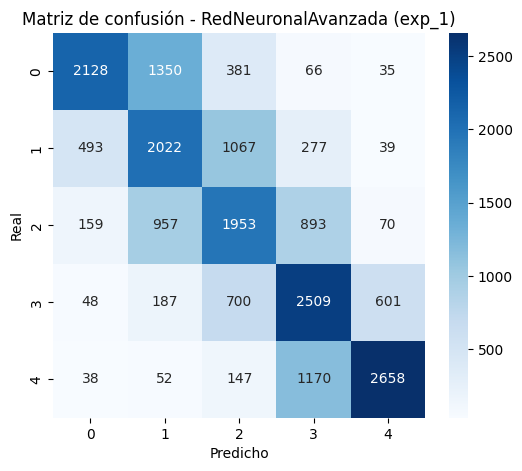


🚀 Entrenando RedNeuronalAvanzada - exp_2
📊 Época 1/400 | Train Acc: 21.58% | Val Acc: 22.62%
🌟 Nuevo mejor modelo!
📊 Época 2/400 | Train Acc: 26.63% | Val Acc: 32.88%
🌟 Nuevo mejor modelo!
📊 Época 3/400 | Train Acc: 35.62% | Val Acc: 40.59%
🌟 Nuevo mejor modelo!
📊 Época 4/400 | Train Acc: 41.32% | Val Acc: 44.82%
🌟 Nuevo mejor modelo!
📊 Época 5/400 | Train Acc: 45.98% | Val Acc: 46.64%
🌟 Nuevo mejor modelo!
📊 Época 6/400 | Train Acc: 48.34% | Val Acc: 45.52%
📊 Época 7/400 | Train Acc: 49.73% | Val Acc: 50.39%
🌟 Nuevo mejor modelo!
📊 Época 8/400 | Train Acc: 51.68% | Val Acc: 52.83%
🌟 Nuevo mejor modelo!
📊 Época 9/400 | Train Acc: 52.95% | Val Acc: 53.27%
🌟 Nuevo mejor modelo!
📊 Época 10/400 | Train Acc: 53.62% | Val Acc: 52.42%
📊 Época 11/400 | Train Acc: 54.42% | Val Acc: 55.43%
🌟 Nuevo mejor modelo!
📊 Época 12/400 | Train Acc: 55.01% | Val Acc: 55.39%
📊 Época 13/400 | Train Acc: 55.68% | Val Acc: 54.63%
📊 Época 14/400 | Train Acc: 56.20% | Val Acc: 56.42%
🌟 Nuevo mejor modelo!
📊 Épo

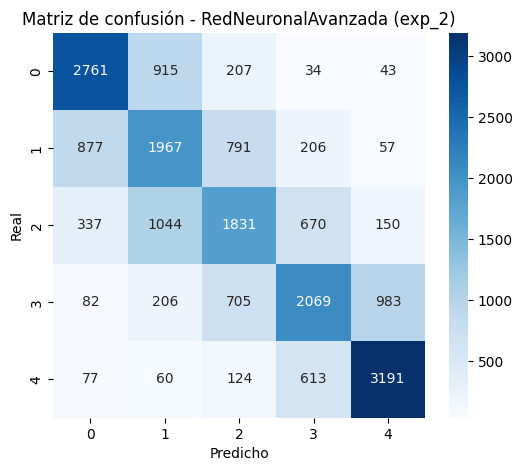


📈 RESUMEN CONSOLIDADO:
                  modelo experimento      lr  batch_size  mejor_epoch  \
0      RedNeuronalSimple       exp_1  0.0010        1024           21   
1      RedNeuronalSimple       exp_2  0.0005        2048           67   
2  RedNeuronalIntermedia       exp_1  0.0010        1024           28   
3  RedNeuronalIntermedia       exp_2  0.0005        2048           57   
4    RedNeuronalAvanzada       exp_1  0.0010        1024           34   
5    RedNeuronalAvanzada       exp_2  0.0005        2048           54   

   mejor_val_accuracy  
0           59.583333  
1           59.694444  
2           59.211111  
3           59.466667  
4           59.261111  
5           59.172222  


In [15]:
# ============================================
# 🚀 Entrenamiento de los 3 modelos con dataset en inglés
# ============================================

# Parámetros generales
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔧 Dispositivo de entrenamiento: {device}")

# Definir vocab_size a partir del tokenizer
vocab_size = tokenizer.vocab_size
print(f"📚 Tamaño del vocabulario: {vocab_size}")

# Modelos disponibles
modelos = {
    "RedNeuronalSimple": lambda: RedNeuronalSimple(vocab_size),
    "RedNeuronalIntermedia": lambda: RedNeuronalIntermedia(vocab_size),
    "RedNeuronalAvanzada": lambda: RedNeuronalAvanzada(vocab_size),
}

# Experimentos definidos
experimentos = {
    "exp_1": {"learning_rate": 0.001, "epochs": 100, "batch_size": 1024},
    "exp_2": {"learning_rate": 0.0005, "epochs": 400, "batch_size": 2048},
}

# Loop de entrenamiento
for nombre_modelo, modelo_fn in modelos.items():
    for exp_name, params in experimentos.items():
        print(f"\n🚀 Entrenando {nombre_modelo} - {exp_name}")

        # DataLoaders
        train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True)
        val_loader   = DataLoader(validation_dataset, batch_size=params["batch_size"])
        test_loader  = DataLoader(test_dataset, batch_size=params["batch_size"])

        # Instanciar modelo
        modelo = modelo_fn().to(device)
        optimizer = optim.Adam(modelo.parameters(), lr=params["learning_rate"])
        criterion = nn.CrossEntropyLoss()

        # Entrenamiento con early stopping
        modelo, best_val_acc, best_epoch, history = train_model_es(
            modelo, train_loader, val_loader, optimizer, criterion,
            epochs=params["epochs"], device=device, patience=25
        )

        # Guardar resultados
        guardar_resultados(nombre_modelo, exp_name, params, best_epoch, best_val_acc, history)

        # Evaluación final en test con métricas adicionales
        evaluar_metricas(modelo, test_loader, criterion, device, nombre_modelo, exp_name)

# Mostrar resumen consolidado
df_resumen = mostrar_resumen()